In [51]:
import pandas as pd
import os
import os.path as op
import glob
import re
import nibabel as nib
import numpy as np

from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
import gzip
import pickle

In [52]:
def dice_coefficient(mask1, mask2):
    """
    Calculate Dice similarity coefficient between two binary masks.
    
    Dice = 2 * |X ∩ Y| / (|X| + |Y|)
    
    Parameters:
    -----------
    mask1, mask2 : array-like or nibabel image
        Binary masks (3D arrays or nibabel images)
    
    Returns:
    --------
    dice : float
        Dice coefficient (0-1, where 1 = perfect overlap)
    """
    # Convert to arrays if nibabel images
    if hasattr(mask1, 'get_fdata'):
        mask1 = mask1.get_fdata()
    if hasattr(mask2, 'get_fdata'):
        mask2 = mask2.get_fdata()
    
    # Flatten and binarize
    mask1_flat = (mask1.flatten() > 0).astype(int)
    mask2_flat = (mask2.flatten() > 0).astype(int)
    
    # Calculate intersection and sizes
    intersection = np.sum(mask1_flat * mask2_flat)
    size1 = np.sum(mask1_flat)
    size2 = np.sum(mask2_flat)
    
    # Avoid division by zero
    if size1 + size2 == 0:
        return 0.0
    
    dice = (2.0 * intersection) / (size1 + size2)
    return dice

In [53]:
def pairwise_dice_scores(roi_files, output_dir=None, force_recalc=False):
    """
    Calculate pairwise Dice coefficients between all subject-specific ROIs.
    Saves results to disk to avoid recomputation.
    
    Parameters:
    -----------
    roi_files : list
        List of file paths to subject-specific ROI NIfTI files
    output_dir : str, optional
        Directory to save/load results. If None, uses directory of first ROI file.
    force_recalc : bool, optional
        If True, recalculate even if saved files exist. Default: False
    
    Returns:
    --------
    dice_matrix : numpy.ndarray
        Symmetric matrix where dice_matrix[i,j] is the Dice coefficient 
        between ROI i and ROI j
    roi_names : list
        List of ROI filenames for indexing the matrix
    pairwise_dice_values : numpy.ndarray
        1D array of unique pairwise Dice values (excluding diagonal)
    
    Notes:
    ------
    Pickle file structure (dict):
        {
            'dice_matrix': numpy.ndarray,
            'roi_names': list,
            'pairwise_dice_values': numpy.ndarray
        }
    
    Load with: import gzip, pickle
               with gzip.open('results.pkl.gz', 'rb') as f:
                   data = pickle.load(f)
               dice_matrix = data['dice_matrix']
               roi_names = data['roi_names']
               pairwise_values = data['pairwise_dice_values']
    """
    import pickle
    import gzip
    
    # Set output directory
    if output_dir is None:
        output_dir = os.path.dirname(roi_files[0])
    os.makedirs(output_dir, exist_ok=True)
    
    # Define output file
    results_file = os.path.join(output_dir, "pairwise_dice_results.pkl.gz")
    
    # Check if results already exist
    if not force_recalc and os.path.exists(results_file):
        print("Loading previously calculated Dice scores from disk...")
        with gzip.open(results_file, 'rb') as f:
            data = pickle.load(f)
        dice_matrix = data['dice_matrix']
        roi_names = data['roi_names']
        pairwise_dice_values = data['pairwise_dice_values']
        print(f"Loaded results for {len(roi_names)} ROIs")
        return dice_matrix, roi_names, pairwise_dice_values
    
    n_rois = len(roi_files)
    dice_matrix = np.zeros((n_rois, n_rois))
    roi_names = [os.path.basename(f) for f in roi_files]
    
    print(f"Calculating pairwise Dice scores for {n_rois} ROIs...")
    print(f"Total comparisons: {n_rois * (n_rois - 1) // 2}")
    
    # Calculate pairwise dice coefficients
    for i in range(n_rois):
        roi1 = nib.load(roi_files[i])
        for j in range(i, n_rois):  # Only upper triangle + diagonal
            if i == j:
                dice_matrix[i, j] = 1.0  # Perfect self-similarity
            else:
                roi2 = nib.load(roi_files[j])
                dice_score = dice_coefficient(roi1, roi2)
                dice_matrix[i, j] = dice_score
                dice_matrix[j, i] = dice_score  # Symmetric matrix
        
        if (i + 1) % 100 == 0:  # Progress update every 100 ROIs
            print(f"Processed {i + 1}/{n_rois} ROIs")
    
    # Extract unique pairwise values (upper triangle, excluding diagonal)
    pairwise_dice_values = dice_matrix[np.triu_indices(n_rois, k=1)]
    
    print("Pairwise Dice calculation completed!")
    print(f"\nSummary Statistics:")
    print(f"Mean Dice: {np.mean(pairwise_dice_values):.3f}")
    print(f"SD Dice: {np.std(pairwise_dice_values):.3f}")
    print(f"Median Dice: {np.median(pairwise_dice_values):.3f}")
    print(f"Range: [{np.min(pairwise_dice_values):.3f}, {np.max(pairwise_dice_values):.3f}]")
    
    # Save results to gzipped pickle file
    print(f"\nSaving results to {results_file}...")
    data = {
        'dice_matrix': dice_matrix,
        'roi_names': roi_names,
        'pairwise_dice_values': pairwise_dice_values
    }
    with gzip.open(results_file, 'wb') as f:
        pickle.dump(data, f)
    print("Results saved successfully!")
    
    return dice_matrix, roi_names, pairwise_dice_values

In [54]:
rois_dir = "./dset/seed-regions"

In [55]:
# Find all subject-specific habenula ROI files (exclude averaged/non-subject files)
subj_rois_dir = op.join(rois_dir, "subj-spec-hbs")
subj_roi_files = sorted(glob.glob(op.join(subj_rois_dir, "sub-*_roi.nii.gz")))

print(f"Found {len(subj_roi_files)} subject ROI files")
print(subj_roi_files[:5])

Found 1482 subject ROI files
['./dset/seed-regions/subj-spec-hbs/sub-0050004_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050005_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050006_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050007_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz', './dset/seed-regions/subj-spec-hbs/sub-0050008_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w_roi.nii.gz']


In [56]:
# Calculate pairwise Dice scores between all subject-specific ROIs
results_path = os.path.join(subj_rois_dir, "pairwise_dice_results.pkl.gz")

if os.path.exists(results_path):
    print(f"Loading existing results from {results_path}...")
    with gzip.open(results_path, 'rb') as f:
        data = pickle.load(f)
    dice_matrix = data['dice_matrix']
    roi_names = data['roi_names']
    pairwise_values = data['pairwise_dice_values']
    print(f"Loaded results for {len(roi_names)} ROIs")
else:
    print("Pickle file not found. Computing pairwise Dice scores...")
    dice_matrix, roi_names, pairwise_values = pairwise_dice_scores(subj_roi_files, subj_rois_dir)
    with gzip.open(results_path, 'wb') as f:
        pickle.dump({
            'dice_matrix': dice_matrix,
            'roi_names': roi_names,
            'pairwise_dice_values': pairwise_values
        }, f)

Loading existing results from ./dset/seed-regions/subj-spec-hbs/pairwise_dice_results.pkl.gz...
Loaded results for 1484 ROIs


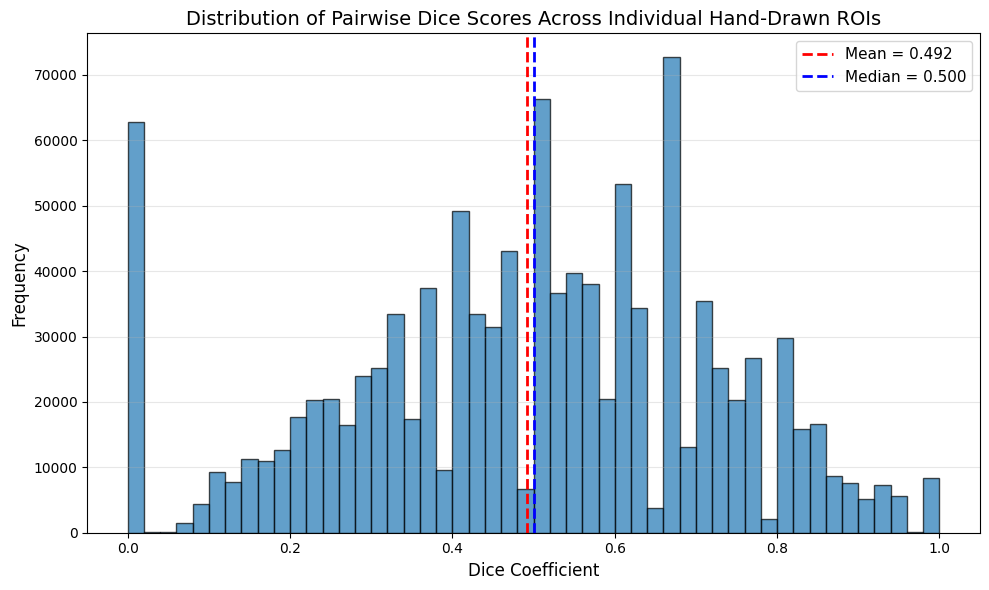

In [57]:
# Create histogram of pairwise Dice scores
results_path = os.path.join(subj_rois_dir, "pairwise_dice_results.pkl.gz")
with gzip.open(results_path, 'rb') as f:
    data = pickle.load(f)

dice_matrix = data['dice_matrix']
roi_names = data['roi_names']
pairwise_values = data['pairwise_dice_values']

plt.figure(figsize=(10, 6))
plt.hist(pairwise_values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Dice Coefficient', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Pairwise Dice Scores Across Individual Hand-Drawn ROIs', fontsize=14)
plt.axvline(np.mean(pairwise_values), color='red', linestyle='--', linewidth=2, 
            label=f'Mean = {np.mean(pairwise_values):.3f}')
plt.axvline(np.median(pairwise_values), color='blue', linestyle='--', linewidth=2,
            label=f'Median = {np.median(pairwise_values):.3f}')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [58]:
# Ensure all NIfTI files are loaded, binarized, and saved in AFNI-compatible format
avg_subj_roi = os.path.join(subj_rois_dir, "subj_averaged_hbroi.nii.gz")

if os.path.exists(avg_subj_roi):
    print(f"Averaged ROI already exists at {avg_subj_roi}")
else:
    afni_nii_files = []
    for i, roi_file in enumerate(subj_roi_files):
        img = nib.load(roi_file)
        data = img.get_fdata()
        # Binarize: set all nonzero voxels to 1
        bin_data = (data > 0).astype(np.uint8)
        bin_img = nib.Nifti1Image(bin_data, img.affine, img.header)
        temp_fn = os.path.join(subj_rois_dir, f"afni_bin_roi_{i}.nii.gz")
        nib.save(bin_img, temp_fn)
        afni_nii_files.append(temp_fn)

    # Use AFNI 3dMean to average all binarized ROIs
    mean_cmd = f"3dMean -prefix {avg_subj_roi} {' '.join(afni_nii_files)}"
    os.system(mean_cmd)

    print(f"Averaged binarized ROI saved to: {avg_subj_roi}")
    # Clean up temporary binarized ROI files
    print("Cleaning up temporary binarized ROI files...")
    for temp_file in afni_nii_files:
        if os.path.exists(temp_file):
            os.remove(temp_file)
            print(f"Deleted: {temp_file}")
    print("Cleanup completed.")

Averaged ROI already exists at ./dset/seed-regions/subj-spec-hbs/subj_averaged_hbroi.nii.gz


In [59]:
# load the atlas based roi
atlas_roi_dir = op.join(rois_dir, "atlas-based-hb")
atlas_roi= glob.glob(op.join(atlas_roi_dir, "*dilated.nii.gz"))

print(atlas_roi)

['./dset/seed-regions/atlas-based-hb/habenula_mni_dilated.nii.gz']


In [60]:

atlas_roi_img = nib.load(atlas_roi[0])  # Take first file from the list
avg_roi_img = nib.load(avg_subj_roi)

atlas_roi_resampled = resample_to_img(atlas_roi_img, avg_roi_img, interpolation='nearest')
print(f"Atlas ROI shape: {atlas_roi_resampled.shape}")


Atlas ROI shape: (97, 115, 97, 1)


/Users/chloehampson/Desktop/habenula-comparison/.venv/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


In [61]:
# Calculate Dice coefficient between subject-averaged ROI and atlas ROI
atlas_vs_subj_dice = dice_coefficient(atlas_roi_resampled, avg_roi_img)

print(f"Dice coefficient between Atlas ROI and Subject-Averaged ROI: {atlas_vs_subj_dice:.4f}")

Dice coefficient between Atlas ROI and Subject-Averaged ROI: 0.6424


In [62]:
# Single iteration: randomly select increasing numbers of subj ROIs,
# average them using AFNI 3dMean (same approach as averaged ROI creation)
np.random.seed(42)

# Create binary ROIs folder
binary_rois_dir = os.path.join(subj_rois_dir, "binary_rois")
os.makedirs(binary_rois_dir, exist_ok=True)

# Create averaged ROIs folder
averaged_rois_dir = os.path.join(subj_rois_dir, "averaged_rois")
os.makedirs(averaged_rois_dir, exist_ok=True)

# Binarize all ROIs once and save to binary_rois folder
print("Binarizing all subject ROIs...")
binary_roi_files = []
for i, roi_file in enumerate(subj_roi_files):
    img = nib.load(roi_file)
    data = img.get_fdata()
    # Binarize: set all nonzero voxels to 1
    bin_data = (data > 0).astype(np.uint8)
    bin_img = nib.Nifti1Image(bin_data, img.affine, img.header)
    
    # Save with same basename but in binary_rois folder
    basename = os.path.basename(roi_file)
    bin_fn = os.path.join(binary_rois_dir, f"bin_{basename}")
    nib.save(bin_img, bin_fn)
    binary_roi_files.append(bin_fn)
    
    if (i + 1) % 100 == 0:
        print(f"Binarized {i + 1}/{len(subj_roi_files)} ROIs")

print(f"Binarized {len(binary_roi_files)}/{len(subj_roi_files)} ROIs")
print(f"All binarized ROIs saved to: {binary_rois_dir}")



Binarizing all subject ROIs...
Binarized 100/1482 ROIs
Binarized 200/1482 ROIs
Binarized 300/1482 ROIs
Binarized 400/1482 ROIs
Binarized 500/1482 ROIs
Binarized 600/1482 ROIs
Binarized 700/1482 ROIs
Binarized 800/1482 ROIs
Binarized 900/1482 ROIs
Binarized 1000/1482 ROIs
Binarized 1100/1482 ROIs
Binarized 1200/1482 ROIs
Binarized 1300/1482 ROIs
Binarized 1400/1482 ROIs
Binarized 1482/1482 ROIs
All binarized ROIs saved to: ./dset/seed-regions/subj-spec-hbs/binary_rois


In [63]:
# Load reference image to get shape and affine
ref_img = nib.load(subj_roi_files[0])

# Load and resample atlas ROI to match subject space
atlas_img = nib.load(atlas_roi[0])
print(atlas_roi[0])
atlas_resampled = resample_to_img(atlas_img, ref_img, interpolation='nearest')


./dset/seed-regions/atlas-based-hb/habenula_mni_dilated.nii.gz


/Users/chloehampson/Desktop/habenula-comparison/.venv/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


In [ ]:
# Define sample sizes: 10, 20, 30, ... up to total number of subjects
n_total = len(binary_roi_files)
print(f"Total number of binary ROIs: {n_total}")

sample_sizes = list(range(10, n_total + 1, 10))
if sample_sizes[-1] != n_total:
    sample_sizes.append(n_total)

print(f"Sample sizes to test: {sample_sizes}")
dice_by_n = []
shuffled_files = np.random.permutation(binary_roi_files).tolist()

print("\nCalculating convergence...")
for n in sample_sizes:
    selected_files = shuffled_files[:n]
    
    # Create a temporary file list to avoid command line length issues
    file_list_path = os.path.join(averaged_rois_dir, f"temp_filelist_n{n}.txt")
    with open(file_list_path, 'w') as f:
        for file_path in selected_files:
            f.write(f"{file_path}\n")
    
    # Use AFNI 3dMean with @ syntax to read file list
    avg_roi_fn = os.path.join(averaged_rois_dir, f"convergence_avg_n{n}.nii.gz")
    mean_cmd = f"3dMean -prefix {avg_roi_fn} `cat {file_list_path}`"
    result = os.system(mean_cmd)
    
    # Clean up temp file list
    os.remove(file_list_path)
    
    if result != 0:
        print(f"WARNING: 3dMean failed for n={n}")
        continue
    
    # Load averaged ROI and calculate Dice against atlas
    avg_img = nib.load(avg_roi_fn)
    dice_score = dice_coefficient(avg_img, atlas_resampled)
    dice_by_n.append(dice_score)
    
    if n % 100 == 0 or n == sample_sizes[-1]:
        print(f"n={n}: Dice = {dice_score:.4f}")

print(f"\nAll averaged ROIs saved to: {averaged_rois_dir}")


Calculating convergence...


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=100: Dice = 0.6714


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=200: Dice = 0.6375


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=300: Dice = 0.6272


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=400: Dice = 0.6000


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=500: Dice = 0.5914


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=600: Dice = 0.6250


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=700: Dice = 0.6173


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=800: Dice = 0.6303


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=900: Dice = 0.6272


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=1000: Dice = 0.6199


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=1100: Dice = 0.6410


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=1200: Dice = 0.6335


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=1300: Dice = 0.6335


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=1400: Dice = 0.6424


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


n=1482: Dice = 0.6424

All averaged ROIs saved to: ./dset/seed-regions/subj-spec-hbs/averaged_rois


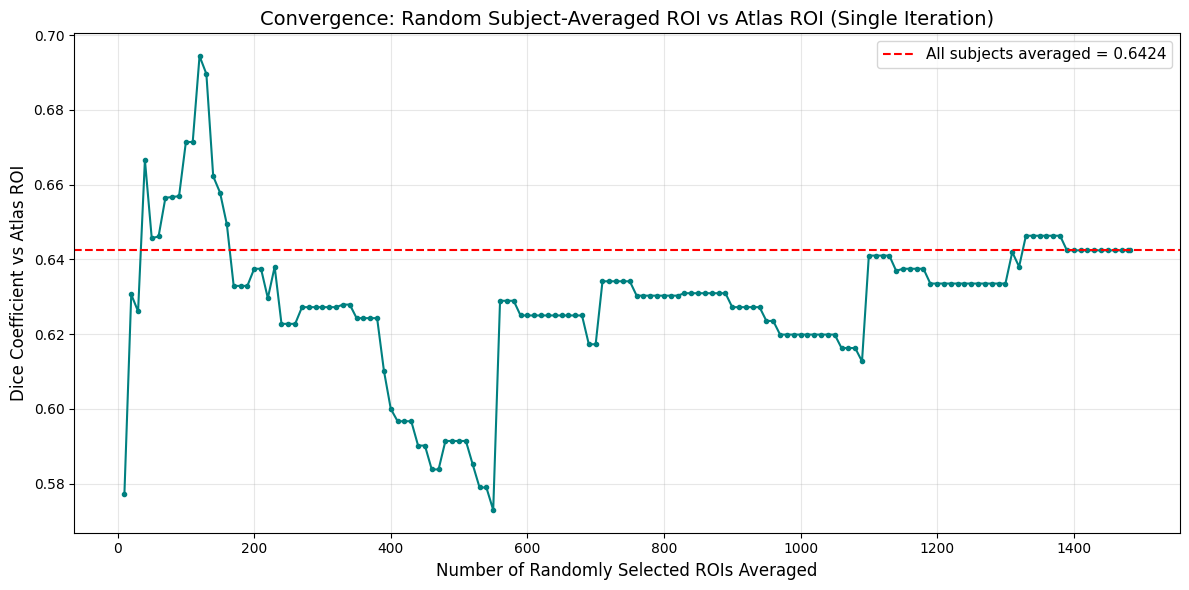

In [67]:
# Plot convergence curve
plt.figure(figsize=(12, 6))
plt.plot(sample_sizes, dice_by_n, 'o-', color='teal', markersize=3, linewidth=1.5)
plt.xlabel('Number of Randomly Selected ROIs Averaged', fontsize=12)
plt.ylabel('Dice Coefficient vs Atlas ROI', fontsize=12)
plt.title('Convergence: Random Subject-Averaged ROI vs Atlas ROI (Single Iteration)', fontsize=14)
plt.axhline(atlas_vs_subj_dice, color='red', linestyle='--', linewidth=1.5,
            label=f'All subjects averaged = {atlas_vs_subj_dice:.4f}')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Define sample sizes: 10, 20, 30, ... up to total number of subjects
n_total = len(binary_roi_files)
print(f"Total number of binary ROIs: {n_total}")

sample_sizes = list(range(10, n_total + 1, 10))
if sample_sizes[-1] != n_total:
    sample_sizes.append(n_total)

print(f"Sample sizes to test: {sample_sizes}")

# Different iteration sets to test
ITERATION_SETS = [5, 10, 15, 20]

# Store results for each iteration set
all_results = {}

for N_ITERATIONS in ITERATION_SETS:
    print(f"\n{'='*70}")
    print(f"RUNNING {N_ITERATIONS} ITERATIONS")
    print(f"{'='*70}")
    
    # Store Dice scores for each iteration
    dice_by_iteration = []
    
    for iteration in range(N_ITERATIONS):
        print(f"\nIteration {iteration + 1}/{N_ITERATIONS}")
        
        dice_by_n = []
        # Different random shuffle for each iteration
        shuffled_files = np.random.permutation(binary_roi_files).tolist()
        
        for n in sample_sizes:
            selected_files = shuffled_files[:n]
            
            # Create a temporary file list to avoid command line length issues
            file_list_path = os.path.join(averaged_rois_dir, f"temp_filelist_iter{iteration}_n{n}.txt")
            with open(file_list_path, 'w') as f:
                for file_path in selected_files:
                    f.write(f"{file_path}\n")
            
            # Use AFNI 3dMean with @ syntax to read file list
            avg_roi_fn = os.path.join(averaged_rois_dir, f"convergence_{N_ITERATIONS}iters_iter{iteration}_n{n}.nii.gz")
            mean_cmd = f"3dMean -prefix {avg_roi_fn} `cat {file_list_path}`"
            result = os.system(mean_cmd)
            
            # Clean up temp file list
            os.remove(file_list_path)
            
            if result != 0:
                print(f"WARNING: 3dMean failed for iteration {iteration}, n={n}")
                dice_by_n.append(np.nan)
                continue
            
            # Load averaged ROI and calculate Dice against atlas
            avg_img = nib.load(avg_roi_fn)
            dice_score = dice_coefficient(avg_img, atlas_resampled)
            dice_by_n.append(dice_score)
        
        dice_by_iteration.append(dice_by_n)
        
        # Progress update
        if (iteration + 1) % 5 == 0 or (iteration + 1) == N_ITERATIONS:
            print(f"Completed {iteration + 1}/{N_ITERATIONS} iterations")
    
    # Calculate mean and SD across iterations for each sample size
    dice_by_iteration = np.array(dice_by_iteration)  # Shape: (N_ITERATIONS, len(sample_sizes))
    mean_dice = np.nanmean(dice_by_iteration, axis=0)
    std_dice = np.nanstd(dice_by_iteration, axis=0)
    
    # Store results
    all_results[N_ITERATIONS] = {
        'mean': mean_dice,
        'std': std_dice,
        'all_dice': dice_by_iteration
    }
    
    print(f"\nMean Dice scores across {N_ITERATIONS} iterations:")
    for i, n in enumerate(sample_sizes):
        if n % 200 == 0 or n == sample_sizes[-1]:
            print(f"n={n}: {mean_dice[i]:.4f} ± {std_dice[i]:.4f}")

print(f"\nAll averaged ROIs saved to: {averaged_rois_dir}")

# Plot all iteration sets on one figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, N_ITERATIONS in enumerate(ITERATION_SETS):
    ax = axes[idx]
    mean_dice = all_results[N_ITERATIONS]['mean']
    std_dice = all_results[N_ITERATIONS]['std']
    
    ax.plot(sample_sizes, mean_dice, 'o-', color='teal', markersize=3, linewidth=1.5, label='Mean Dice')
    ax.fill_between(sample_sizes, mean_dice - std_dice, mean_dice + std_dice, 
                     color='teal', alpha=0.2, label='±1 SD')
    ax.axhline(atlas_vs_subj_dice, color='red', linestyle='--', linewidth=1.5,
                label=f'All subjects = {atlas_vs_subj_dice:.4f}')
    ax.set_xlabel('Number of Randomly Selected ROIs Averaged', fontsize=11)
    ax.set_ylabel('Dice Coefficient vs Atlas ROI', fontsize=11)
    ax.set_title(f'{N_ITERATIONS} Iterations', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('Convergence Analysis: Effect of Number of Iterations', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary comparison plot: SD at different sample sizes across iteration counts
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['blue', 'green', 'orange', 'red']

for idx, N_ITERATIONS in enumerate(ITERATION_SETS):
    std_dice = all_results[N_ITERATIONS]['std']
    ax.plot(sample_sizes, std_dice, 'o-', color=colors[idx], markersize=3, 
            linewidth=1.5, label=f'{N_ITERATIONS} iterations')

ax.set_xlabel('Number of Randomly Selected ROIs Averaged', fontsize=12)
ax.set_ylabel('Standard Deviation of Dice Coefficient', fontsize=12)
ax.set_title('Stability Across Iterations: How SD Changes with Sample Size', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Total number of binary ROIs: 1482
Sample sizes to test: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430, 1440, 1450, 1460, 1470, 1480, 1482]

RUNNING 5 ITERATIONS

Iteration 1/5


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (De


Iteration 2/5


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (De

++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]



Iteration 3/5


++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]
++ 3dMean: AFNI version=AFNI_25.3.00 (Dec  1 2025) [64-bit]


In [66]:
# # 10 iterations: randomly select increasing numbers of subj ROIs,
# # average them, compute Dice vs atlas, then average across iterations
# n_iterations = 10
# n_total = len(subj_roi_files)

# sample_sizes = list(range(10, n_total + 1, 10))
# if sample_sizes[-1] != n_total:
#     sample_sizes.append(n_total)

# # Store Dice scores for each iteration
# all_dice_scores = np.zeros((n_iterations, len(sample_sizes)))

# for iteration in range(n_iterations):
#     print(f"Iteration {iteration + 1}/{n_iterations}...")
#     shuffled_files = np.random.permutation(subj_roi_files).tolist()
    
#     for s_idx, n in enumerate(sample_sizes):
#         selected_files = shuffled_files[:n]
        
#         # Binarize and average selected ROIs using numpy
#         roi_stack = []
#         for roi_file in selected_files:
#             img = nib.load(roi_file)
#             data = img.get_fdata()
#             bin_data = (data > 0).astype(np.float64)
#             roi_stack.append(bin_data)
        
#         # Average across subjects
#         avg_roi = np.mean(roi_stack, axis=0)
        
#         # Create averaged image
#         avg_img = nib.Nifti1Image(avg_roi, ref_img.affine, ref_img.header)
        
#         # Calculate Dice against atlas
#         dice_score = dice_coefficient(avg_img, atlas_resampled)
#         all_dice_scores[iteration, s_idx] = dice_score

# # Calculate mean and std across iterations
# mean_dice = np.mean(all_dice_scores, axis=0)
# std_dice = np.std(all_dice_scores, axis=0)

# print(f"\nResults averaged over {n_iterations} iterations:")
# for s_idx, n in enumerate(sample_sizes):
#     if n % 100 == 0 or n == sample_sizes[-1] or n == 10:
#         print(f"n={n}: Mean Dice = {mean_dice[s_idx]:.4f} ± {std_dice[s_idx]:.4f}")

# # Plot convergence curve with error bands
# plt.figure(figsize=(12, 6))
# plt.plot(sample_sizes, mean_dice, 'o-', color='teal', markersize=3, linewidth=1.5,
#          label='Mean Dice (10 iterations)')
# plt.fill_between(sample_sizes, mean_dice - std_dice, mean_dice + std_dice,
#                  alpha=0.2, color='teal', label='± 1 SD')
# plt.axhline(atlas_vs_subj_dice, color='red', linestyle='--', linewidth=1.5,
#             label=f'All subjects averaged = {atlas_vs_subj_dice:.4f}')
# plt.xlabel('Number of Randomly Selected ROIs Averaged', fontsize=12)
# plt.ylabel('Dice Coefficient vs Atlas ROI', fontsize=12)
# plt.title(f'Convergence: Random Subject-Averaged ROI vs Atlas ROI ({n_iterations} Iterations)', fontsize=14)
# plt.legend(fontsize=11)
# plt.grid(alpha=0.3)
# plt.tight_layout()
# plt.show()